# Bouncing LLaMa! 🦙
>  A silly experiment to learn a bit more about LLMs and finetuning.
> 
> By Chase Shimmin

## The idea:
After a very interesting conversation with [@Susmit Jha](https://susmitjha.github.io/), I've been thinking about how LLMs might learn to reason about physical processes that are expressed in a non-standard language representation.

I decided it would be fun to find out if the LLM could learn the "rules" of a physical system by simply observing the resultant state of its evolution. It's not that different to how human physicists come up with a theoretical understanding of nature. As [Feynman put it](https://nemoslibrary.com/2016/09/28/the-chess-game-analogy-feynman-on-the-laws-of-nature/):
> [...] what we’re doing in trying to understand nature is to imagine that the gods are playing some great game like chess. [...] And you don’t know the rules of the game, but you’re allowed to look at the board at least from time to time and in a little corner, perhaps. And from these observations, you try to figure out what the rules are of the game, what are the rules of the pieces moving.
> You might discover after a bit, for example, that when there’s only one bishop around on the board, that the bishop maintains its color. Later on you might discover the law for the bishop is that it moves on a diagonal, which would explain the law that you understood before, that it maintains its color.
>
> –Richard Feynman _“The Pleasure of Finding Things Out”_

## The toy problem:
After musing for a bit, I concieved an idea to have the LLM learn the physics of a ball bouncing around in a maze-like box, with ideal elastic collisions and no external forces. That is, the ball moves in straight lines at constant velocity, until it hits a wall, at which point its velocity is reflected about the surface normal.

First, I wrote a simple procedural generator to randomly synthesize such environments comprised of vertical and horizontal walls; see my other notebook [bounce-sim.ipynb](bounce-sim.ipynb). The environments look something like this:

```
            +-----------------------+------------------------+
            |                       |                        |
            |                  |    |                        |
            +---------------   |    |                        |
            |                  |    |                        |
            |                  |    |                        |
            |                  |    |                        |
            |                  |    |                        |
            |                       |                        |
            |    |                  |            |           |
            |    |                | |            |           |
            |    |               -+-+----------              |
            |    |                |                          |
            |                     |                          |
            |                                                |
            |                                                |
            |                                                |
            |                                                |
            +------------------------------------------------+
```

The physical simulation begins by selecting a random point, and an _intercardinal direction_, i.e. SW,NW,NE,SE. Then, the ball proceeds at a constant velocity of √2, responding to collisions as needed. A trajectory might look like this:

```
            +-----------------------+------------------------+
            |           *  /\       |                        |
            |            \/  \ |    |                        |
            +---------------  \|    |                        |
            | /\              /|    |                        |
            |/  \            / |    |                        |
            |\   \          /  |    |                        |
            | \   \        /   |    |                        |
            |  \   \      /         |                        |
            |   \|  ➘    /          |            |           |
            |   /|      /         | |            |           |
            |  / |     /         -+-+----------              |
            | /  |    /           |                          |
            |/       /            |                          |
            |\      /                                        |
            | \    /                                         |
            |  \  /                                          |
            |   \/                                           |
            +------------------------------------------------+
```
where the `*` indicates the starting position, and the initial velocity was southeast (SE).

To make things more interesting, and to maintain some semblance of a language-oriented task, I represented each timestep along the trajectory using the ordered characters from a given quote in the prompt (I got a big list of famous quotes from a random .csv on github). For example, if the quote was:

🔴 `I'm sorry Dave, I'm afraid I can't do that.`

The final result would be:

```
            +-----------------------+------------------------+
            |           I   s       |                        |
            |            'm  o |    |                        |
            +---------------  r|    |                        |
            |  d              r|    |                        |
            |t  o            y |    |                        |
            |'                 |    |                        |
            | n   t        D   |    |                        |
            |  a   h      a         |                        |
            |   c|  a    v          |            |           |
            |    |   t  e         | |            |           |
            |  I |    .,         -+-+----------              |
            |    |                |                          |
            |d       I            |                          |
            |i      '                                        |
            | a    m                                         |
            |  r                                             |
            |   fa                                           |
            +------------------------------------------------+
```

## Will it work?
Honestly, it works about as well as I thought it might. What truly surprised me is how well it worked, given the very limited amount of training (about 2 epochs on 10k examples).

If you think about it, it's not at all obvious that an LLM would be suited for this kind of task. The first question that comes to mind is whether the tokenizer will be able to reasonably cope with this kind of input, since it is very different from the (natural) language inputs that it is largely trained on.

Even more worrisome, there is limited, and highly inconsistent locality between "adjacent" letters in the output. Keep in mind that the actual input to the LLM is essentially one long line of tokens; it does not intrinsically see the 2D structure the way human eyes, or even image CNNs, naturally do.

For example, the sequence of characters between the first two letters "D" and "a" in *Da*ve becomes:

`D   |    |                        |\n            |  a   h      a`

while the sequence between "a" and "f" in *af*raid is:
`fa`.

We're being extra mean to the LLM here by allowing the number of columns to vary between examples!


On the other hand, it's not totally implausible that it _could_ learn something like this. The pairwise representation of inputs that is developed within the transformer architecture, simliarly to GNNs, can effectively be used to represent discrete locations on a grid. It's possible, but unlike in a CNN, it's not _required_ to, and I certainly don't expect this structure to be something it has spontaneously learned during training on the NLP corpus. The question is, will fine tuning be enough?

## Let's do this!
Enough yammering, onto the code. The basics of fine tuning LLaMa using PEFT was largely based on Meta's own [finetuning quickstart](https://github.com/meta-llama/llama-recipes/blob/main/recipes/quickstart/finetuning/quickstart_peft_finetuning.ipynb) in the `llama_recipes` repo. I've added additional comments and illustrations on the dataset that's being trained throughout.

In [1]:
from IPython.display import display, Markdown
import numpy as np
import matplotlib.pyplot as plt
import torch

import huggingface_hub

In [2]:
huggingface_hub.login()

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


### Step 1: Load LLaMa 3.1-8B

Setup training configuration and load the model and tokenizer.

In [3]:
from transformers import LlamaForCausalLM, AutoTokenizer
from llama_recipes.configs import train_config as TRAIN_CONFIG

train_config = TRAIN_CONFIG()
train_config.model_name = "meta-llama/Meta-Llama-3.1-8B"
train_config.num_epochs = 1
train_config.run_validation = False
train_config.gradient_accumulation_steps = 4
#train_config.batch_size_training = 1
train_config.lr = 3e-4
train_config.use_fast_kernels = True
train_config.use_fp16 = True
#train_config.context_length = 1024 if torch.cuda.get_device_properties(0).total_memory < 16e9 else 2048 # T4 16GB or A10 24GB

# I optimized the context size a bit so that with packing it would max out the ram on 4090
train_config.batch_size_training = 3
train_config.context_length = 1280 

train_config.batching_strategy = "packing"
train_config.output_dir = "bounce-quotes"

from transformers import BitsAndBytesConfig
config = BitsAndBytesConfig(
    load_in_8bit=True,
)

model = LlamaForCausalLM.from_pretrained(
            train_config.model_name,
            device_map="auto",
            quantization_config=config,
            use_cache=False,
            attn_implementation="sdpa" if train_config.use_fast_kernels else None,
            torch_dtype=torch.float16,
        )

tokenizer = AutoTokenizer.from_pretrained(train_config.model_name)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

### Step 2: Load and format the toy dataset

We can use the 1k sample for eval and 10k for training.

In [9]:
import pickle
with open('bounce1k.pkl', 'rb') as fpkl:
    dataset1k = pickle.load(fpkl)

with open('bounce10k.pkl', 'rb') as fpkl:
    dataset10k = pickle.load(fpkl)

In [5]:
# Turns the pickled dataset entries into a textual prompt and answer, for feeding into the LLM.
def format_sample(sample):
    prompt = f"""\
Let's play the bouncy letters game!

__Starting direction:__ `{sample['direction']}`

__Reference text:__ `{sample['quote']}`

__Playing field:__
```
{sample['field']}
```
__Answer:__

"""
    answer = f"""\
```
{sample['answer']}
```
"""
    return {'prompt': prompt, 'answer': answer}

#### A formatted prompt/answer looks like this:

In [28]:
ieval = 226
formatted = format_sample(dataset1k[ieval])
display(Markdown(formatted['prompt'] + formatted['answer']))

Let's play the bouncy letters game!

__Starting direction:__ `SE`

__Reference text:__ `The unexamined life is not worth living.`

__Playing field:__
```
+-------------------------+--------------------------------------------------------+
|                         |                                                        |
|                         |                                                        |
|                         |                                                        |
|               |         |                                                        |
|               |         |                                                        |
|                         |                                                        |
|                         |                                               |        |
|                         |                                               |        |
|   *                     |                                               |        |
|                         |                              |                |        |
|                         |                              |                |        |
|                                                        |                |        |
|                                                        |                |        |
|             -------------------------------------------+                |        |
|                                                        |                         |
|                                                        |                         |
|                                                        |                         |
|   |                                                    |                         |
|   |                                                    |                         |
|   |                                                                              |
|   |                                                                              |
+---+---------------------                                                         |
|   |                                                                              |
|   |                                                                              |
+---+------------------------------------------------------------------------------+
```
__Answer:__

```
+-------------------------+--------------------------------------------------------+
|                         |                                                        |
|                         |                                                        |
|                         |                                                        |
|               |         |                                                        |
|               |         |                                                        |
|                         |                                                        |
|                         |                                               |        |
|                         |                                               |        |
|   T                     |                                               |        |
|    h                    |                              |                |        |
|     e                   |                              |                |        |
|                                                        |                |        |
|       u                                                |                |        |
|        n    -------------------------------------------+                |        |
|         e             i                                |                         |
|          x             s                 .             |                         |
|           a         e                   g              |                         |
|   |        m       f     n             n               |                         |
|   |         i     i       o           i                |                         |
|   |          n   l         t         v                                           |
|   |           e                     i                                            |
+---+------------d--------     w     l                                             |
|   |                           o                                                  |
|   |                            r h                                               |
+---+-----------------------------t------------------------------------------------+
```


### Step 3: Inspect tokenizer

Since the format of these prompts/answers are not very "standard" text data, I was interested to see how many tokens they use.

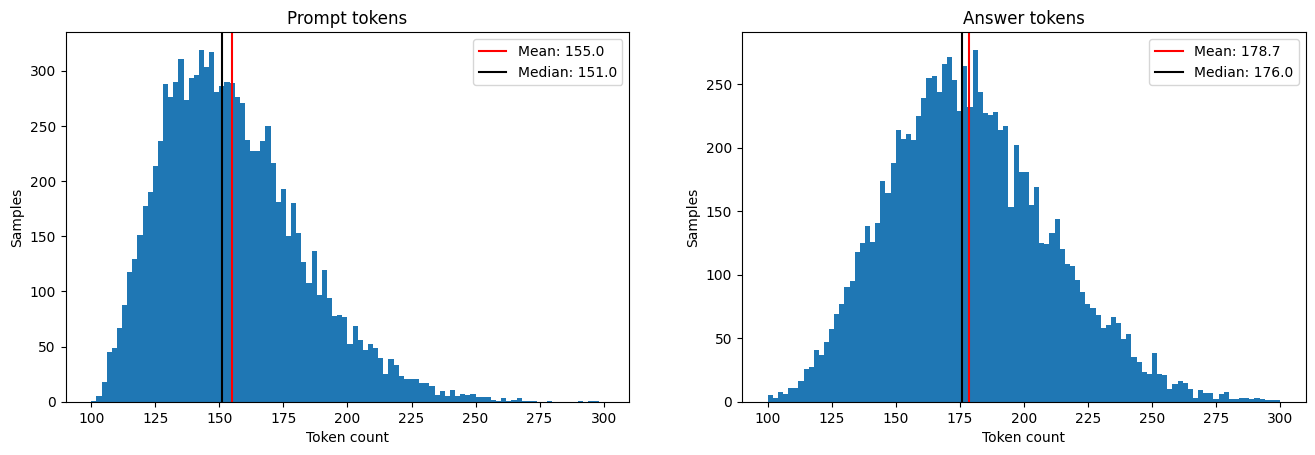

In [10]:
# get some statistics on the token count of the prompts:
ntokens_prompt = [len(tokenizer.encode(format_sample(samp)['prompt'])) for samp in dataset10k]
ntokens_answer = [len(tokenizer.encode(format_sample(samp)['answer'])) for samp in dataset10k]

plt.figure(figsize=plt.figaspect(0.3))
plt.subplot(121)
plt.hist(ntokens_prompt, range=(100,300), bins=100);
plt.xlabel("Token count")
plt.ylabel("Samples");
mean, med = np.mean(ntokens_prompt), np.median(ntokens_prompt)
plt.axvline(mean, color='red', label=f'Mean: {mean:.1f}')
plt.axvline(med, color='black', label=f'Median: {med:.1f}')
plt.legend()
plt.title("Prompt tokens");

plt.subplot(122)
plt.hist(ntokens_answer, range=(100,300), bins=100);
plt.xlabel("Token count")
plt.ylabel("Samples");
mean, med = np.mean(ntokens_answer), np.median(ntokens_answer)
plt.axvline(mean, color='red', label=f'Mean: {mean:.1f}')
plt.axvline(med, color='black', label=f'Median: {med:.1f}')
plt.legend()
plt.title("Answer tokens");

### Step 4: Test untrained model response


In [12]:
eval_prompt = format_sample(dataset1k[ieval])['prompt']

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    display(Markdown(tokenizer.decode(model.generate(**model_input, max_new_tokens=180)[0], skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Let's play the bouncy letters game!

__Starting direction:__ `SE`

__Reference text:__ `The unexamined life is not worth living.`

__Playing field:__
```
+-------------------------+--------------------------------------------------------+
|                         |                                                        |
|                         |                                                        |
|                         |                                                        |
|               |         |                                                        |
|               |         |                                                        |
|                         |                                                        |
|                         |                                               |        |
|                         |                                               |        |
|   *                     |                                               |        |
|                         |                              |                |        |
|                         |                              |                |        |
|                                                        |                |        |
|                                                        |                |        |
|             -------------------------------------------+                |        |
|                                                        |                         |
|                                                        |                         |
|                                                        |                         |
|   |                                                    |                         |
|   |                                                    |                         |
|   |                                                                              |
|   |                                                                              |
+---+---------------------                                                         |
|   |                                                                              |
|   |                                                                              |
+---+------------------------------------------------------------------------------+
```
__Answer:__

```
+-------------------------+--------------------------------------------------------+
|                         |                                                        |
|                         |                                                        |
|                         |                                                        |
|               |         |                                                        |
|               |         |                                                        |
|                         |                                                        |
|                         |                                               |        |
|                         |                                               |        |
|   *                     |                                               |        |
|                         |                              |                |        |
|                         |                              |                |        |
|                                                        |                |        |
|                                                        |                |        |
|             -------------------------------------------+                |        |
|                                                        |                         |
|                                                        |                         |
|                                                        |                         |
|   |                                                    |                         |
|   |                                                    |                         |
|   |                                                                              |
|   |                                                                              |
+---+---------------------                                                         |
|   |                                                                              |
|   |                                                                              |
+---+------------------------------------------------------------------------------+
```


#### Interestingly, the models' out-of-the-box behavior to repeat the playing field.
(If you rerun it several times, it occasionaly tries to make up rules to the "bouncy letters game" instead.)

### Step 5: Configure model for PEFT

Prepare the model for Parameter Efficient Fine Tuning (PEFT), and set the optimizer/LR scheduler config.

In [14]:
from peft import get_peft_model, prepare_model_for_kbit_training, LoraConfig
from dataclasses import asdict
from llama_recipes.configs import lora_config as LORA_CONFIG

lora_config = LORA_CONFIG()
lora_config.r = 8
lora_config.lora_alpha = 32
lora_dropout: float=0.01

peft_config = LoraConfig(**asdict(lora_config))

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

In [16]:
import torch.optim as optim
from llama_recipes.utils.train_utils import train
from torch.optim.lr_scheduler import StepLR


optimizer = optim.AdamW(
            model.parameters(),
            lr=train_config.lr,
            weight_decay=train_config.weight_decay,
        )
scheduler = StepLR(optimizer, step_size=1, gamma=train_config.gamma)

### Step 6: Preprocess text dataset for LLM ingestion

Split the prompt/answer segments, tokenize, and configure the response labels.

In [21]:
def get_preprocessed_bounce(tokenizer, split='10k'):
    import pickle
    with open(f'bounce{split}.pkl', 'rb') as fpkl:
        dataset_raw = pickle.load(fpkl)

    def tokenize_add_label(sample):
        sample = format_sample(sample)
        prompt = tokenizer.encode(tokenizer.bos_token + sample['prompt'], add_special_tokens=False)
        answer = tokenizer.encode(sample['answer'] +  tokenizer.eos_token, add_special_tokens=False)

        sample = {
            "input_ids": prompt + answer,
            "attention_mask" : [1] * (len(prompt) + len(answer)),
            "labels": [-100] * len(prompt) + answer,
            }

        return sample

    return list(map(tokenize_add_label, dataset_raw))

And set up the dataloader:

In [22]:
from llama_recipes.data.concatenator import ConcatDataset
from llama_recipes.utils.config_utils import get_dataloader_kwargs

train_config.batch_size_training = 3
#train_config.batching_strategy = "padding"
#train_config.context_length = 1024

train_dataset = get_preprocessed_bounce(tokenizer)

train_dl_kwargs = get_dataloader_kwargs(train_config, train_dataset, tokenizer, "train")
train_dl_kwargs['shuffle'] = True

if train_config.batching_strategy == "packing":
        train_dataset = ConcatDataset(train_dataset, chunk_size=train_config.context_length)

# Create DataLoaders for the training and validation dataset
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    num_workers=train_config.num_workers_dataloader,
    pin_memory=True,
    **train_dl_kwargs,
)

Preprocessing dataset: 100%|██████████| 10000/10000 [00:00<00:00, 57119.53it/s]


In [23]:
len(train_dataset), len(train_dataset[0]['input_ids'])

(2607, 1280)

### Step 7: Train!

In [58]:
# Start the training process

train_config.num_epochs = 1

model.train()

results = train(
    model,
    train_dataloader,
    None,
    tokenizer,
    optimizer,
    scheduler,
    train_config.gradient_accumulation_steps,
    train_config,
    None,
    None,
    None,
    wandb_run=None,
)

Training Epoch: 1:   0%|          | 0/217 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch: 1/1, step 868/869 completed (loss: 0.15003350377082825): : 218it [39:52, 10.97s/it]                       1.00s/it]


Max CUDA memory allocated was 19 GB
Max CUDA memory reserved was 21 GB
Peak active CUDA memory was 19 GB
CUDA Malloc retries : 0
CPU Total Peak Memory consumed during the train (max): 4 GB
Epoch 1: train_perplexity=1.1977, train_epoch_loss=0.1804, epoch time 2392.51251274487s


### Step 8: Check trained model performance
This time we just show the answer segment of the response.

This is an example from the evaluation dataset. We can see that it's definitely trying to write some of the words along diagonals, and it even gets one collision/reflection correct!

In [72]:
eval_prompt = format_sample(dataset1k[ieval])['prompt']

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    response = tokenizer.decode(model.generate(**model_input, max_new_tokens=200)[0], skip_special_tokens=True)

# just print the answer part:
display(Markdown(response[len(eval_prompt):]))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


```
+-------------------------+--------------------------------------------------------+
|                         |                                                        |
|                         |                                                        |
|                         |                                                        |
|               |         |                                                        |
|               |         |                                                        |
|                         |                                                        |
|                         |                                               |        |
|                         |                                               |        |
|   T                     |                                               |        |
|  h                      |                              |                |        |
| e                       |                              |                |        |
|                         .                                               |        |
| u                       g|                |                |                |        |
|  n                     n |                |                |                |        |
|   a                   i  -------------------------------------------+                |
|    x                 v             l                                   |                         |
|     e               i             i v                                    |                         |
|      m             l             v i                                     |                         |
|   |    i           g           i t                                      |                         |
|   |     n         n         n g                                         |                         |
|   |      e

For reference, here's the ground truth again; we can see that it did not actually use the correct starting direction from the prompt.

In [79]:
display(Markdown(format_sample(dataset1k[ieval])['answer']))

```
+-------------------------+--------------------------------------------------------+
|                         |                                                        |
|                         |                                                        |
|                         |                                                        |
|               |         |                                                        |
|               |         |                                                        |
|                         |                                                        |
|                         |                                               |        |
|                         |                                               |        |
|   T                     |                                               |        |
|    h                    |                              |                |        |
|     e                   |                              |                |        |
|                                                        |                |        |
|       u                                                |                |        |
|        n    -------------------------------------------+                |        |
|         e             i                                |                         |
|          x             s                 .             |                         |
|           a         e                   g              |                         |
|   |        m       f     n             n               |                         |
|   |         i     i       o           i                |                         |
|   |          n   l         t         v                                           |
|   |           e                     i                                            |
+---+------------d--------     w     l                                             |
|   |                           o                                                  |
|   |                            r h                                               |
+---+-----------------------------t------------------------------------------------+
```


What if we modify the original prompt to so that the initial velocity is northeast instead of southeast? Turns out it still does the same direction.
But although the columns are all jumbled up, it has some impressive reflections on the horizontal walls!

In [76]:
eval_prompt = format_sample({**dataset1k[ieval], 'direction': 'NE'})['prompt']

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    response = tokenizer.decode(model.generate(**model_input, max_new_tokens=200)[0], skip_special_tokens=True)

# just print the answer part:
display(Markdown(response[len(eval_prompt):]))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


```
+-------------------------+--------------------------------------------------------+
|                         |                                                        |
|                         |                                                        |
|                         |                                                        |
|               |         |                                                        |
|               |         |                                                        |
|                         |                                                        |
|                         |                                               |        |
|                         |                                               |        |
|   T                     |                                               |        |
|  h                      |                              |                |        |
| e                       |                              |                |        |
|u                                                        |                |        |
| n                                                        |                |        |
|  a-------------------------------------------+                |        |
|   m           l           t       i          |                         |
|    e         i           h       v           |                         |
|     d       v     s     t   t   i            |                         |
|   |  i     i       i   o     h n             |                         |
|   |   f   n         s n       g              |                         |
|   |    e g           g      .

### Step 8: Save model checkpoint
Waste not want not...

In [82]:
train_config.output_dir = 'bouncy-quotes-v1'
model.save_pretrained(train_config.output_dir)

## Conclusion
I will actually revise my statement from the introduction (I added another epoch of training between now and then). This really is working better than I expected! The model is clearly learning something about how to write text on diagonals, but even more impressively, it seems to be starting to get the hang of reflections at the collision boundaries. On the other hand, it seems to be struggling with maintaining the column structure of the "maze" when characters are inserted within a row. It jumbles up the words that it's supposed to be writing. And, it appears to be ignoring the direction input entirely.

It could just be a matter of more training! Fortunately, we can generate arbitrarily many training examples. GPU time, on the other hand is not as cheap, so for now I leave it here ;)